In [5]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [6]:
#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

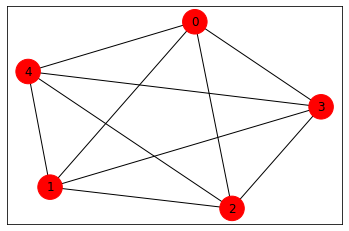

In [13]:
import networkx as nx
import numpy as np

# Generating the butterfly graph with 5 nodes 
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(0,3,1.0),(0,4,1.0),(1,2,1.0),(1,3,1.0),(1,4,1.0),(2,3,1.0),(2,4,1.0),(3,4,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [ ]:
params = {}
algo = QAOA.init_params()

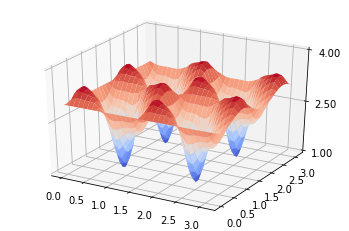


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [15]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest paramters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

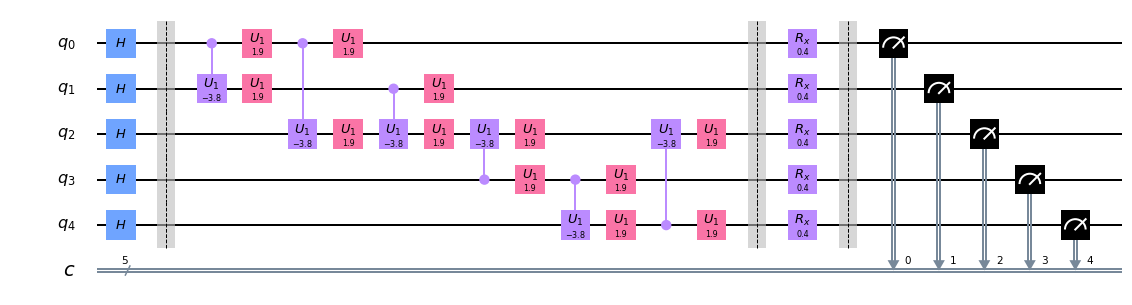

In [9]:
# preapre the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cu1(-2*gamma, k, l)
    QAOA.u1(gamma, k)
    QAOA.u1(gamma, l)
    
# then apply the single qubit X - rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw(output='mpl')

In [10]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

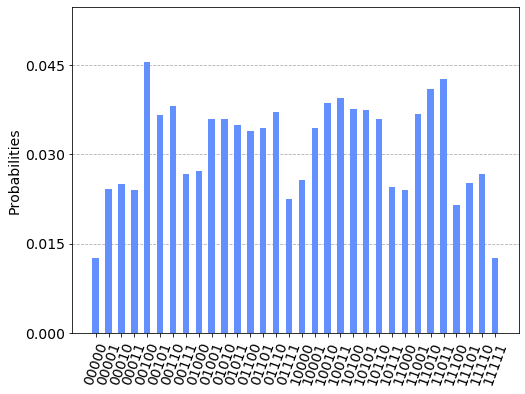

In [11]:
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(QAOA, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.30 while the true value is M1 = 3.43 

The approximate solution is x* = 01010 with C(x*) = 4 

The cost function is distributed as: 



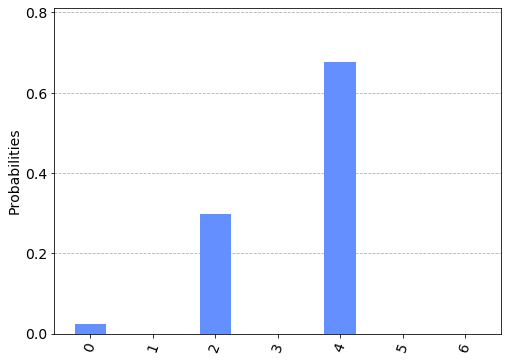

In [12]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

In [ ]:
# Use the IBMQ essex device
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_essex')
shots   = 2048

job_exp = execute(QAOA, backend=backend, shots=shots)
job_monitor(job_exp)

exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8),bar_labels = False)

In [ ]:
# Evaluate the data from the experiment
counts = exp_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

SyntaxError: invalid syntax (<ipython-input-1-a6fe0cfb91df>, line 3)

In [18]:
from collections import OrderedDict
import numpy as np
from qiskit.quantum_info import Pauli
from qiskit.aqua import operators
from qiskit.aqua.algorithms.adaptive import QAOA
from qiskit.aqua.components.optimizers import *
from qiskit.aqua import QuantumInstance
import networkx as nx
from qiskit.aqua import get_aer_backend

def sample_most_likely(state_vector):
    if isinstance(state_vector, dict) or isinstance(state_vector, OrderedDict):
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x
def get_qubitops(input):
    w = np.array(input.tolist())
    num_nodes = len(w)
    pauli_list = []
    shift = 0
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if w[i, j] != 0:
                xp = np.zeros(num_nodes, dtype=np.bool)
                zp = np.zeros(num_nodes, dtype=np.bool)
                zp[i] = True
                zp[j] = True
                pauli_list.append([w[i, j], Pauli(zp, xp)])
                shift += 1
    for i in range(num_nodes):
        degree = np.sum(w[i, :])
        xp = np.zeros(num_nodes, dtype=np.bool)
        zp = np.zeros(num_nodes, dtype=np.bool)
        zp[i] = True
        pauli_list.append([w[i, i], Pauli(zp, xp)])
    return Operator(paulis=pauli_list)

from qiskit import IBMQ
IBMQ.load_account()

def get_backend(backend_str):
    if backend_str == 'qasm_simulator':
        backend = get_aer_backend(backend_str)
    elif backend_str == 'ibmq_16_melbourne' or backend_str == 'ibmqx4':
        backend = IBMQ.get_backend(backend_str)
    else:
        print("Choose a valid backend")
        return
    return backend

def solve_ibmqx_ising_qubo(G, matrix_func, optimizer, p, backend_str='qasm_simulator'):
        backend = get_backend(backend_str)
        w = matrix_func(G)
        ops = get_qubitops(w)
        qaoa = QAOA(ops, optimizer, p, operator_mode='paulis')
        quantum_instance = QuantumInstance(backend)
        result = qaoa.run(quantum_instance)
        x = sample_most_likely(result['eigvecs'][0])
        return x


Credentials are already in use. The existing account in the session will be replaced.


In [21]:
import os
import sys
d = os.path.dirname(os.getcwd())+'/utils'
sys.path.append(d)
#from graphs import *
#from qubo_ising_generators import *
#from classical_solvers import *
import networkx as nx
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

def maximum_cut_qubo_dwave(G):
        Q = {}
        for a in list(G.edges()):
                Q[a] = 2
        for i in list(G.nodes()):
                Q[(i, i)] = -1*G.degree(i)
        return Q

def max_cut_qubo_matrix_ibmqx(G):
        qubo = maximum_cut_qubo_dwave(G)
        data = np.zeros((len(G), len(G)))
        for a in qubo:
                data[a[0], a[1]] = qubo[a]
                data[a[1], a[0]] = qubo[a]
        return data

def ibqmx_qaoa(G, optimizer, func, r):
        app_ratio = 0
        qubo_main = []
        counter = 0
        for avg in range(0, 100):
            counter += 1
            result_out = solve_ibmqx_ising_qubo(G, func, optimizer, r)
            result2 = []
            for i in result_out:
                  if i == 0:
                        result2.append(1)
                  if i == 1:
                        result2.append(0)
            x = max_cut_value(result2, G)
            qubo_main.append(x)
            app_ratio += x
            print(float(app_ratio)/float(counter))

print('maxcut')
out = []
for r in range(1, 20):
    G = nx.gnp_random_graph(7, 0.5, 101)
    res = ibqmx_qaoa(G, SLSQP(), max_cut_qubo_matrix_ibmqx, r)
    out.append(res)
    print(out)

maxcut


NameError: name 'Operator' is not defined